In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
import pandas as pd
import tensorflow as tf
import keras, tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import regularizers

In [2]:
df = pd.read_csv("/Users/hanzichun/desktop/Optiver-07/Data/S27FE-10K.csv")

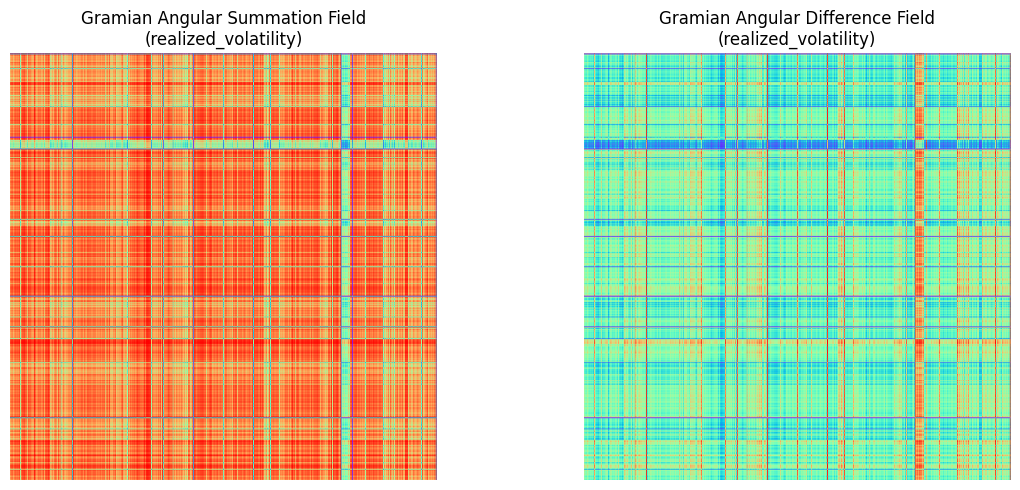

In [3]:
def plot_gaf(df: pd.DataFrame, column_name: str) -> None:
    ts = df[column_name].values
    ts_min, ts_max = ts.min(), ts.max()
    ts_norm = 2 * (ts - ts_min) / (ts_max - ts_min) - 1
    X = np.array([ts_norm])
    gasf = GramianAngularField(method='summation')
    gadf = GramianAngularField(method='difference')
    X_gasf = gasf.fit_transform(X)
    X_gadf = gadf.fit_transform(X)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(X_gasf[0], cmap='rainbow', origin='lower')
    plt.title(f'Gramian Angular Summation Field\n({column_name})')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(X_gadf[0], cmap='rainbow', origin='lower')
    plt.title(f'Gramian Angular Difference Field\n({column_name})')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_gaf(df, 'realized_volatility')

In [4]:
window_size = 20
horizon = 1
n_samples = len(df) - window_size - horizon + 1
X_images = []
y = []
gasf = GramianAngularField(method='summation')

from sklearn.preprocessing import MinMaxScaler

for i in range(n_samples):
    ts_window = df["realized_volatility"].iloc[i : i + window_size].values
    scaler = MinMaxScaler(feature_range=(-1, 1))
    ts_norm = scaler.fit_transform(ts_window.reshape(-1, 1)).flatten()
    ts_norm = ts_norm.reshape(1, -1)
    gaf_image = gasf.fit_transform(ts_norm)
    X_images.append(gaf_image[0])
    
    label = df["realized_volatility"].iloc[i + window_size + horizon - 1]
    y.append(label)


X_images = np.array(X_images)
y = np.array(y)
X_images = X_images[..., np.newaxis]
split_index = int(0.8 * len(X_images))
X_train, X_test = X_images[:split_index], X_images[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

model = Sequential([
    Conv2D(16, kernel_size=(3, 3), activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           input_shape=(window_size, window_size, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(32, kernel_size=(3, 3), activation='relu',
           kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.6),

    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    shuffle=False,
    verbose=1
)


test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss (MSE): {test_loss}')

y_pred = model.predict(X_test)

/Users/hanzichun/Desktop/Optiver-07/volt/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0940 - val_loss: 0.0241
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0180 - val_loss: 0.0067
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0052 - val_loss: 0.0022
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017 - val_loss: 8.1160e-04
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.5289e-04 - val_loss: 3.2494e-04
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6395e-04 - val_loss: 1.3874e-04
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1275e-04 - val_loss: 6.2398e-05
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.0050e-05 - val_loss: 2.9594e-05
Epoch 9/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2912e-05 - val_loss: 1.5136e-05
Epoch 10/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0910e-05 - val_loss: 8.7418e-06
Epoch 11/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.6045e-06 - va

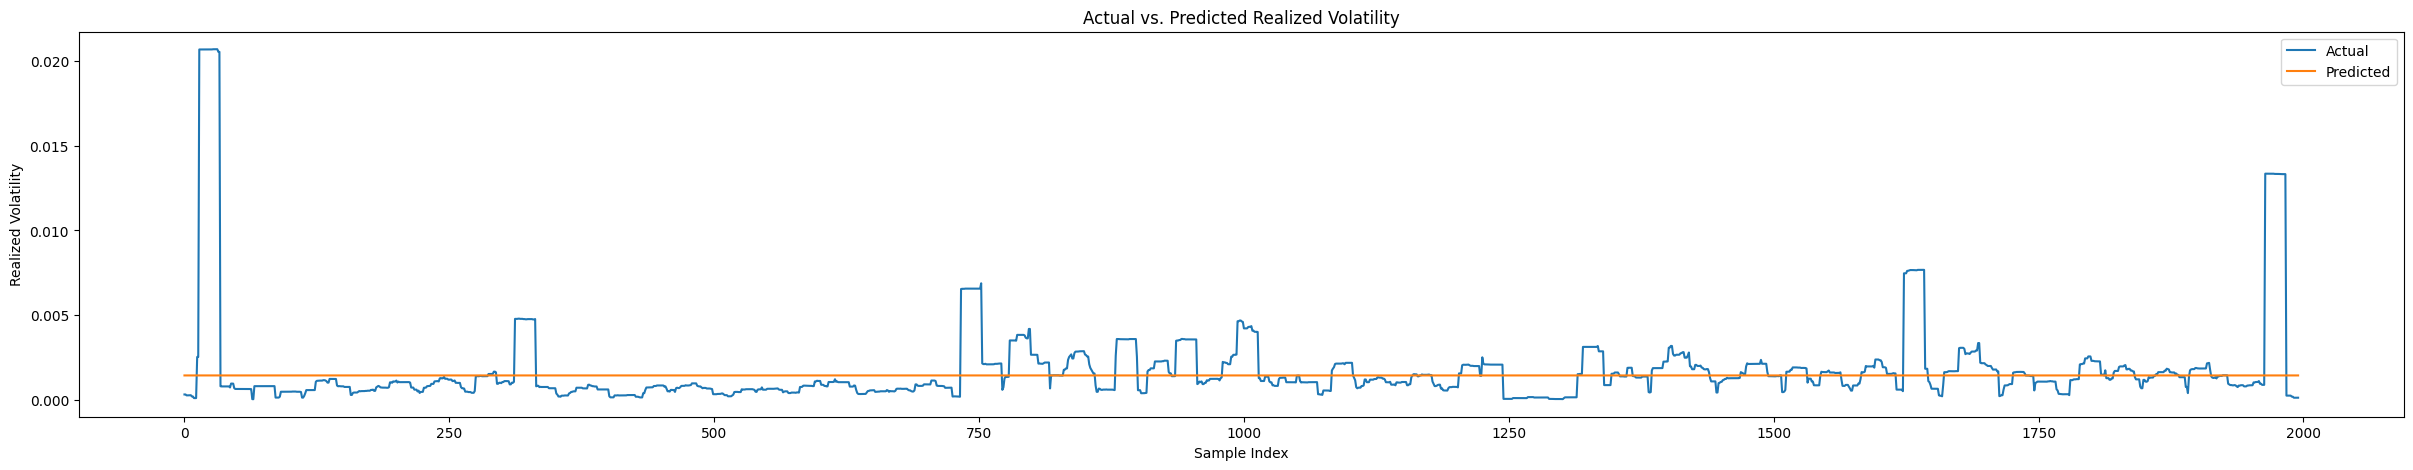

In [5]:
plt.figure(figsize=(30, 5))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Realized Volatility')
plt.title('Actual vs. Predicted Realized Volatility')
plt.legend()
plt.show()

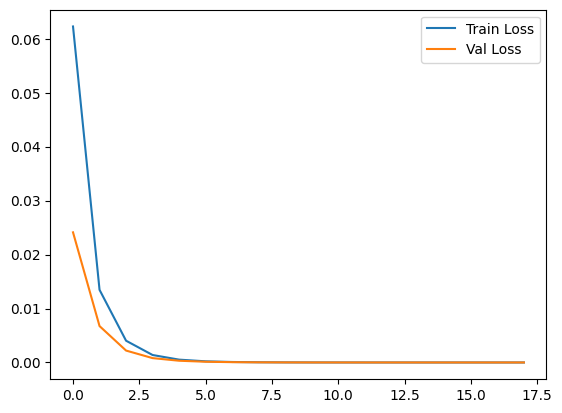

In [6]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()